In [1]:
# make a script that is readable, modular, and can cleanly generate Table 1
# ideally, we want this to output a tsv that can be pulled into Excel directly

In [75]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from scipy.stats import fisher_exact, ranksums
import matplotlib.pyplot as plt
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# this table contains metadata we can use for phenotype definition and stratification
group_fn_pheno = 'gs://popgen-gwas/data/metadata/Annotated_GenotypedData/OmniH3Merged_PrePost2016_AggregatedLASVPhenotypes_20210829.tsv'
groups_pheno = pd.read_csv(group_fn_pheno, sep='\t')
groups_pheno.head(10)

,#IID,SEX,Batch,SampleType,Disease,Epoch,Epoch_Bin,Country,Age,CollectionEpoch,...,Pre2016_SL_LASV_qPCR1xPos,Pre2016_SL_LASV_SeqPos,Pre2016_SL_LASV_AgPos,Pre2016_SL_LASV_AgORSeqPos,Pre2016_SL_LASV_PopControl,Pre2016_SL_LASV_IgPosPopControl,Pre2016_SL_LASV_IgNegPopControl,Pre2016_SL_LASV_IgGNegPopControl,Pre2016_SL_LASV_AgORSeqPos_DC,Pre2016_SL_LASV_AgORSeqPos_Died
0,WG0284565-DNA_A02_G-5231,2,1,SuspectedEbolaSL,Ebola,Post2016,1,1,38.0,Post2016,...,False,False,False,False,False,False,False,False,False,False
1,WG0284565-DNA_A03_G-5686,2,1,SuspectedEbolaSL,Ebola,Post2016,1,1,10.0,Post2016,...,False,False,False,False,False,False,False,False,False,False
2,WG0284565-DNA_A04_G-5690,1,1,SuspectedEbolaSL,Ebola,Post2016,1,1,16.0,Post2016,...,False,False,False,False,False,False,False,False,False,False
3,WG0284565-DNA_A05_G-5135,2,1,SuspectedEbolaSL,Ebola,Post2016,1,1,49.0,Post2016,...,False,False,False,False,False,False,False,False,False,False
4,WG0284565-DNA_A06_G-5045,2,1,SuspectedEbolaSL,Ebola,Post2016,1,1,24.0,Post2016,...,False,False,False,False,False,False,False,False,False,False
5,WG0284565-DNA_A07_G-5510,1,1,SuspectedEbolaSL,Ebola,Post2016,1,1,40.0,Post2016,...,False,False,False,False,False,False,False,False,False,False
6,WG0284565-DNA_A08_G-7030,1,1,SuspectedLassaSL,Lassa,Post2016,1,1,41.0,Post2016,...,False,False,False,False,False,False,False,False,False,False
7,WG0284565-DNA_A09_G-7022,2,1,SuspectedLassaSL,Lassa,Post2016,1,1,13.0,Post2016,...,False,False,False,False,False,False,False,False,False,False
8,WG0284565-DNA_A10_G-5687,2,1,SuspectedEbolaSL,Ebola,Post2016,1,1,19.0,Post2016,...,False,False,False,False,False,False,False,False,False,False
9,WG0284565-DNA_A11_G-5135,2,1,SuspectedEbolaSL,Ebola,Post2016,1,1,49.0,Post2016,...,False,False,False,False,False,False,False,False,False,False


In [4]:
final_samples = pd.read_csv('gs://popgen-gwas/data/genotype/merge/Unimputed/OmniH3Merged_PrePost2016.20210817.FiltSLOmni5.Geno_1e-1.filtBatchvars20220107.Deduped.fam', sep=' ', header=None)
final_samples.head()

,0,1,2,3,4,5
0,0,WG0284565-DNA_A02_G-5231,0,0,2,2
1,0,WG0284565-DNA_A03_G-5686,0,0,2,2
2,0,WG0284565-DNA_A04_G-5690,0,0,1,2
3,0,WG0284565-DNA_A05_G-5135,0,0,2,2
4,0,WG0284565-DNA_A06_G-5045,0,0,2,2


In [5]:
final_ind = groups_pheno['#IID'].isin(final_samples[1])
final_ind.value_counts()

True     4914
False     641
Name: #IID, dtype: int64

In [6]:
groups_pheno = groups_pheno.loc[final_ind, :]

In [7]:
groups_pheno.shape

(4914, 50)

In [8]:
def create_table(data, case_col):
    total = data[case_col].value_counts()
    sex = pd.crosstab(data[case_col], data['SEX'].replace({1:'Female', 2:'Male'}))
    epoch = pd.crosstab(data[case_col], data['CollectionEpoch'])
    epoch = epoch.loc[:, ['Pre2016', 'Post2016']]
    array = pd.crosstab(data[case_col], data['Batch'].replace({1:'H3', 2:'H3', 25:'Omni2.5M', 26:'Omni2.5M', 50:'Omni5M'}))
    array = array.loc[:, ['Omni2.5M', 'Omni5M', 'H3']]
    mean_age = data.groupby(case_col)['Age'].mean()
    sd_age = data.groupby(case_col)['Age'].std()
    fracmissing_age = data.groupby(case_col)['Age'].agg(lambda x: x.isnull().mean())
    mean_age.name = 'Age_Mean'
    sd_age.name = 'Age_SD'
    fracmissing_age.name = 'Age_FracMissing'

    table = pd.concat([total, sex, epoch, array, mean_age, sd_age, fracmissing_age], axis=1)
    table = table.loc[['Control', 'Case'], :]
    table = table.rename(columns={case_col:'Total', 'Pre2016':'2008-2014','Post2016':'2016-2018' })

    for c in ['Female', 'Male', '2008-2014', '2016-2018', 'Omni2.5M', 'Omni5M', 'H3']:
        z = ((table[c]/table['Total'])*100).apply(lambda x: np.around(x,1))
        table[c] = table[c].astype(str) + ' (' + z.astype(str) + '%)'
    return(table)   

In [9]:
ng_ind = (groups_pheno['Country']==0) #& (groups_pheno['Disease']=='Lassa')
groups_pheno_ng = groups_pheno.loc[ng_ind, :]


case_col = 'Main_Case_Status'
groups_pheno_ng[case_col] = 'null'
cases = ['Post2016_NG_LASV_ExactLVMatchqPCR2xPosOrSeqPos', 'Pre2016_NG_LASV_qPCR1xPos', 'Pre2016_NG_LASV_SeqPos'] 
controls = ['Pre2016_NG_LASV_PopControl', 'Post2016_NG_LASV_PopControl']
for c in cases:
    groups_pheno_ng.loc[groups_pheno_ng[c], case_col] = 'Case'
    
for c in controls:
    groups_pheno_ng.loc[groups_pheno_ng[c], case_col] = 'Control'

groups_pheno_ng = groups_pheno_ng.loc[groups_pheno_ng[case_col].isin(['Case', 'Control']), :]
groups_pheno_ng.head()

/opt/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/miniconda3/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,#IID,SEX,Batch,SampleType,Disease,Epoch,Epoch_Bin,Country,Age,CollectionEpoch,...,Pre2016_SL_LASV_SeqPos,Pre2016_SL_LASV_AgPos,Pre2016_SL_LASV_AgORSeqPos,Pre2016_SL_LASV_PopControl,Pre2016_SL_LASV_IgPosPopControl,Pre2016_SL_LASV_IgNegPopControl,Pre2016_SL_LASV_IgGNegPopControl,Pre2016_SL_LASV_AgORSeqPos_DC,Pre2016_SL_LASV_AgORSeqPos_Died,Main_Case_Status
1169,WG0284582-DNA_A05_SM-87W5V,2,1,TriosNG,Lassa,Post2016,1,0,38.0,Pre2016,...,False,False,False,False,False,False,False,False,False,Control
1170,WG0284582-DNA_A06_SM-NEIDU,2,1,TriosNG,Lassa,Post2016,1,0,20.0,Pre2016,...,False,False,False,False,False,False,False,False,False,Control
1174,WG0284582-DNA_A11_SM-5X7Q1,2,1,TriosNG,Lassa,Post2016,1,0,40.0,Pre2016,...,False,False,False,False,False,False,False,False,False,Control
1203,WG0284582-DNA_D05_SM-45CMW,2,1,TriosNG,Lassa,Post2016,1,0,30.0,Pre2016,...,False,False,False,False,False,False,False,False,False,Control
1204,WG0284582-DNA_D06_SM-656GK,1,1,TriosNG,Lassa,Post2016,1,0,67.0,Pre2016,...,False,False,False,False,False,False,False,False,False,Control


In [10]:
ct = pd.crosstab(groups_pheno_ng['SEX'].replace({1:'Female', 2:'Male', np.nan:'Null'}), groups_pheno_ng[case_col])
print(fisher_exact(ct))
ct

(1.9880228114247616, 2.974198479987219e-09)


Main_Case_Status,Case,Control
SEX,,
Female,242,497
Male,169,690


In [11]:
case_age = groups_pheno_ng.loc[groups_pheno_ng[case_col]=='Case', 'Age'].dropna()
control_age = groups_pheno_ng.loc[groups_pheno_ng[case_col]=='Control', 'Age'].dropna()
ranksums(case_age, control_age)

RanksumsResult(statistic=-2.7504160530402118, pvalue=0.005951963988792897)

In [12]:
case_age.dropna().median(), control_age.dropna().median()

(32.0, 36.0)

In [13]:
samp_vc = groups_pheno_ng.loc[groups_pheno_ng[case_col]=='Control', 'SampleType'].value_counts()
samp_vc

Pre2016ControlNG    612
TriosNG             549
NG-C-Control         21
NG-FUC-Control        5
Name: SampleType, dtype: int64

In [14]:
table_ng = create_table(groups_pheno_ng, case_col)
table_ng

/opt/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  from ipykernel import kernelapp as app


,Total,Female,Male,2008-2014,2016-2018,Omni2.5M,Omni5M,H3,Age_Mean,Age_SD,Age_FracMissing
Control,1187,497 (41.9%),690 (58.1%),1161 (97.8%),26 (2.2%),756 (63.7%),387 (32.6%),44 (3.7%),37.215372,16.115603,0.002527
Case,411,242 (58.9%),169 (41.1%),107 (26.0%),304 (74.0%),91 (22.1%),3 (0.7%),317 (77.1%),35.202618,17.856761,0.024331


In [15]:
groups_pheno_ng['Outcome'] = 'Unknown'
groups_pheno_ng.loc[groups_pheno_ng['Post2016_NG_LASV_ExactLVMatchqPCR2xPosOrSeqPos_Died'], 'Outcome'] = 'Deceased'
groups_pheno_ng.loc[groups_pheno_ng['Post2016_NG_LASV_ExactLVMatchqPCR2xPosOrSeqPos_DC'], 'Outcome'] = 'Survived'
groups_pheno_ng.loc[groups_pheno_ng['Pre2016_NG_LASV_qPCRorSeq+_Died'], 'Outcome'] = 'Deceased'
groups_pheno_ng.loc[groups_pheno_ng['Pre2016_NG_LASV_qPCRorSeq+_DC'], 'Outcome'] = 'Survived'
outcome_vc = groups_pheno_ng.loc[groups_pheno_ng[case_col]=='Case', 'Outcome'].value_counts()
outcome_vc_frac = outcome_vc.drop('Unknown')
outcome_vc_frac = outcome_vc_frac / outcome_vc_frac.sum()

table_ng['Deceased'] = ''
table_ng['Survived'] = ''

for v in ['Deceased', 'Survived']:
    table_ng.at['Case', v] = '%d (%.1f)' % (outcome_vc.at[v], 100*outcome_vc_frac[v])

In [16]:
outcome_vc

Survived    198
Deceased    107
Unknown     106
Name: Outcome, dtype: int64

In [17]:
table_ng

,Total,Female,Male,2008-2014,2016-2018,Omni2.5M,Omni5M,H3,Age_Mean,Age_SD,Age_FracMissing,Deceased,Survived
Control,1187,497 (41.9%),690 (58.1%),1161 (97.8%),26 (2.2%),756 (63.7%),387 (32.6%),44 (3.7%),37.215372,16.115603,0.002527,,
Case,411,242 (58.9%),169 (41.1%),107 (26.0%),304 (74.0%),91 (22.1%),3 (0.7%),317 (77.1%),35.202618,17.856761,0.024331,107 (35.1),198 (64.9)


In [18]:
table_ng.to_csv('../../tables/table1_NG_noqPCRNeg.tsv', sep='\t')

In [19]:
sl_ind = (groups_pheno['Country']==1) #& (groups_pheno['Disease']=='Lassa')
groups_pheno_sl = groups_pheno.loc[sl_ind, :]

case_col = 'Main_Case_Status'
groups_pheno_sl[case_col] = 'null'

cases = ['Pre2016_SL_LASV_AgORSeqPos', 'Post2016_SL_LASV_AgPos'] 
controls = ['Pre2016_SL_LASV_PopControl']

for c in cases:
    groups_pheno_sl.loc[groups_pheno_sl[c], case_col] = 'Case'
    
for c in controls:
    groups_pheno_sl.loc[groups_pheno_sl[c], case_col] = 'Control'

groups_pheno_sl = groups_pheno_sl.loc[groups_pheno_sl[case_col].isin(['Case', 'Control']), :]
groups_pheno_sl[case_col].value_counts()

/opt/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Control    799
Case       122
Name: Main_Case_Status, dtype: int64

In [20]:
ct = pd.crosstab(groups_pheno_sl['SEX'].replace({1:'Female', 2:'Male'}), groups_pheno_sl[case_col])
print(fisher_exact(ct))
ct

(1.0180898491083676, 0.9215457339795612)


Main_Case_Status,Case,Control
SEX,,
Female,50,324
Male,72,475


In [21]:
case_age = groups_pheno_sl.loc[groups_pheno_sl[case_col]=='Case', 'Age'].dropna()
control_age = groups_pheno_sl.loc[groups_pheno_sl[case_col]=='Control', 'Age'].dropna()
ranksums(case_age, control_age)

RanksumsResult(statistic=-8.485604537369227, pvalue=2.146001046876553e-17)

In [22]:
case_age.median(), control_age.median()

(23.5, 36.0)

In [23]:
samp_vc = groups_pheno_sl.loc[groups_pheno_sl[case_col]=='Control', 'SampleType'].value_counts()
samp_vc

Pre2016ControlSL    564
TriosSL             195
PopControlSL         40
Name: SampleType, dtype: int64

/opt/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """
/opt/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  # This is added back by InteractiveShellApp.init_path()
/opt/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


Text(0.5, 0, 'Age')

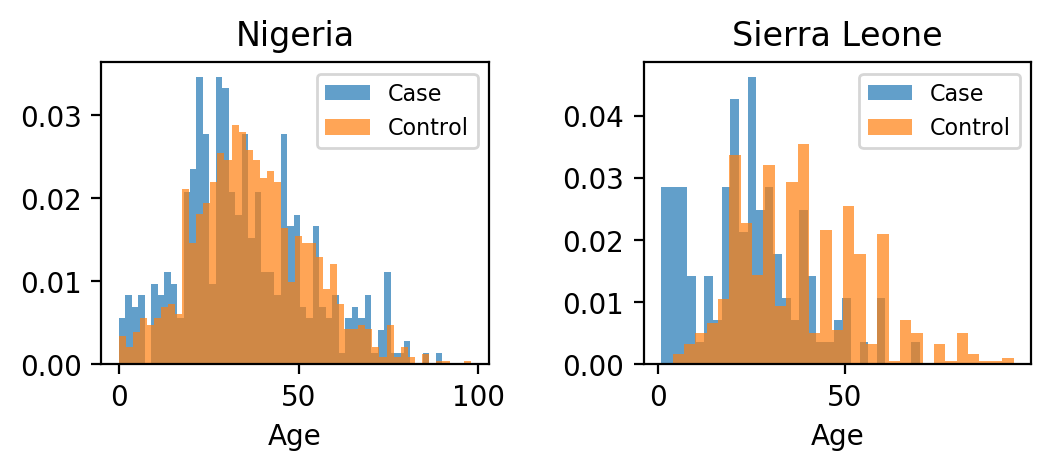

In [46]:
(fig,axes) = plt.subplots(1,2, figsize=(6,2), dpi=200, gridspec_kw={'wspace':.4})
axes[0].hist(groups_pheno_ng.loc[groups_pheno_ng[case_col]=='Case', 'Age'].dropna(),
             bins=50, normed=True, label='Case', alpha=.7)
_ = axes[0].hist(groups_pheno_ng.loc[groups_pheno_ng[case_col]=='Control', 'Age'].dropna(),
                 bins=50, normed=True, label='Control', alpha=.7)
axes[0].set_title('Nigeria')
axes[0].legend(fontsize=8)
axes[0].set_xlabel('Age')

axes[1].hist(groups_pheno_sl.loc[groups_pheno_sl[case_col]=='Case', 'Age'].dropna(),
             bins=30, normed=True, label='Case', alpha=.7)
_ = axes[1].hist(groups_pheno_sl.loc[groups_pheno_sl[case_col]=='Control', 'Age'].dropna(),
                 bins=30, normed=True, label='Control', alpha=.7)
axes[1].set_title('Sierra Leone')
axes[1].legend(fontsize=8)
axes[1].set_xlabel('Age')


Text(0, 0.5, 'Fraction of cohort')

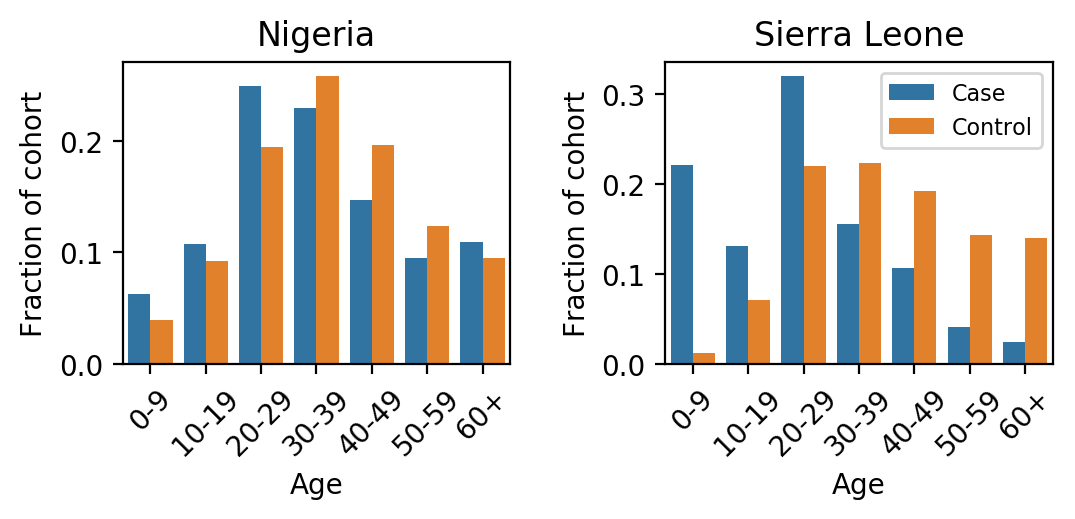

In [90]:
cut_bins = [0, 10, 20, 30, 40, 50, 60, 100]
mapping = {'[40.0, 50.0)':'40-49', '[10.0, 20.0)':'10-19', '[0.0, 10.0)':'0-9', '[20.0, 30.0)':'20-29',
       '[30.0, 40.0)':'30-39', '[50.0, 60.0)':'50-59', 'nan':np.nan, '[60.0, 100.0)':'60+'}


ind = ~groups_pheno_ng['Age'].isnull()
groups_pheno_ng['Age_Bin'] = np.nan
groups_pheno_ng['Age_Bin'] = pd.cut(groups_pheno_ng['Age'], bins=cut_bins, right=False).astype(str).replace(mapping)

ind = ~groups_pheno_sl['Age'].isnull()
groups_pheno_sl['Age_Bin'] = np.nan
groups_pheno_sl['Age_Bin'] = pd.cut(groups_pheno_sl['Age'], bins=cut_bins, right=False).astype(str).replace(mapping)
groups_pheno_sl['Age_Bin'].unique()

ng_age_frac = []
for (k,g) in groups_pheno_ng.groupby(case_col):
    vc = g['Age_Bin'].dropna().value_counts()
    frac = pd.DataFrame(vc / vc.sum())
    frac[case_col] = k
    ng_age_frac.append(frac)

ng_age_frac = pd.concat(ng_age_frac, axis=0).reset_index()


sl_age_frac = []
for (k,g) in groups_pheno_sl.groupby(case_col):
    vc = g['Age_Bin'].dropna().value_counts()
    frac = pd.DataFrame(vc / vc.sum())
    frac[case_col] = k
    sl_age_frac.append(frac)
    
sl_age_frac = pd.concat(sl_age_frac, axis=0).reset_index()

order = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60+']
(fig,axes) = plt.subplots(1,2, figsize=(6,2), dpi=200, gridspec_kw={'wspace':.4})

sns.barplot(x='index', y='Age_Bin', hue=case_col, data=ng_age_frac, ax=axes[0], order=order)
axes[0].set_title('Nigeria')
axes[0].legend(fontsize=8)
axes[0].set_xlabel('Age')
axes[0].set_xticklabels(order, rotation=45)
axes[0].set_ylabel('Fraction of cohort')
axes[0].get_legend().remove()

sns.barplot(x='index', y='Age_Bin', hue=case_col, data=sl_age_frac, ax=axes[1], order=order)
axes[1].set_title('Sierra Leone')
axes[1].legend(fontsize=8)
axes[1].set_xlabel('Age')
axes[1].set_xticklabels(order, rotation=45)
axes[1].set_ylabel('Fraction of cohort')

In [32]:
table_sl = create_table(groups_pheno_sl, case_col)
table_sl

/opt/miniconda3/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:1404: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/opt/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  from ipykernel import kernelapp as app


,Total,Female,Male,2008-2014,2016-2018,Omni2.5M,Omni5M,H3,Age_Mean,Age_SD,Age_FracMissing
Control,799,324 (40.6%),475 (59.4%),799 (100.0%),0 (0.0%),753 (94.2%),nan (nan%),46 (5.8%),38.815126,16.632271,0.255319
Case,122,50 (41.0%),72 (59.0%),84 (68.9%),38 (31.1%),84 (68.9%),nan (nan%),38 (31.1%),24.127049,14.873650,0.000000


In [33]:
groups_pheno_sl['Outcome'] = 'Unknown'

cases = ['Post2016_SL_LASV_AgPos_Died', 'Pre2016_SL_LASV_AgORSeqPos_Died'] 
controls = ['Post2016_SL_LASV_AgPos_DC', 'Pre2016_SL_LASV_AgORSeqPos_DC']
for c in cases:
    groups_pheno_sl.loc[groups_pheno_sl[c], 'Outcome'] = 'Deceased'
    
for c in controls:
    groups_pheno_sl.loc[groups_pheno_sl[c], 'Outcome'] = 'Survived'

outcome_vc = groups_pheno_sl.loc[groups_pheno_sl[case_col]=='Case', 'Outcome'].value_counts()
outcome_vc_frac = outcome_vc.drop('Unknown')
outcome_vc_frac = outcome_vc_frac / outcome_vc_frac.sum()

table_sl['Deceased'] = ''
table_sl['Survived'] = ''

for v in ['Deceased', 'Survived']:
    table_sl.at['Case', v] = '%d (%.1f)' % (outcome_vc.at[v], 100*outcome_vc_frac[v])

In [34]:
outcome_vc

Deceased    70
Survived    38
Unknown     14
Name: Outcome, dtype: int64

In [35]:
table_sl

,Total,Female,Male,2008-2014,2016-2018,Omni2.5M,Omni5M,H3,Age_Mean,Age_SD,Age_FracMissing,Deceased,Survived
Control,799,324 (40.6%),475 (59.4%),799 (100.0%),0 (0.0%),753 (94.2%),nan (nan%),46 (5.8%),38.815126,16.632271,0.255319,,
Case,122,50 (41.0%),72 (59.0%),84 (68.9%),38 (31.1%),84 (68.9%),nan (nan%),38 (31.1%),24.127049,14.873650,0.000000,70 (64.8),38 (35.2)


In [36]:
table_sl = table_sl.drop('Omni5M', axis=1)

In [37]:
table_sl.to_csv('../../tables/table1_SL_noEVDCC.tsv', sep='\t')
table_sl 

,Total,Female,Male,2008-2014,2016-2018,Omni2.5M,H3,Age_Mean,Age_SD,Age_FracMissing,Deceased,Survived
Control,799,324 (40.6%),475 (59.4%),799 (100.0%),0 (0.0%),753 (94.2%),46 (5.8%),38.815126,16.632271,0.255319,,
Case,122,50 (41.0%),72 (59.0%),84 (68.9%),38 (31.1%),84 (68.9%),38 (31.1%),24.127049,14.873650,0.000000,70 (64.8),38 (35.2)
